# Convert STRING to a 2d embedding using UMAP

In [1]:
import umap
import scipy.sparse
import pandas as pd

from utils import get_string_dataset_path

In [2]:
# Show the head of protein info
gene_path = get_string_dataset_path("protein.info")
gene_df = pd.read_csv(gene_path, sep='\t')
gene_df = gene_df.reset_index()
gene_df.tail(2)

,index,protein_external_id,preferred_name,protein_size,annotation
19564,19564,9606.ENSP00000485675,ENSG00000280116,84,annotation not available
19565,19565,9606.ENSP00000485678,OR6Q1,317,Olfactory receptor 6Q1; Odorant receptor; Olfa...


In [3]:
%%time
matrix = scipy.sparse.load_npz("data/score-matrices/combined_score.sparse.npz")

CPU times: user 734 ms, sys: 35.2 ms, total: 770 ms
Wall time: 801 ms


In [4]:
reducer = umap.UMAP(
    n_components=2,
    random_state=0,
    init="random", # https://github.com/lmcinnes/umap/issues/381
)

In [5]:
%%time
mapper = reducer.fit(matrix)

CPU times: user 29min 44s, sys: 3.06 s, total: 29min 48s
Wall time: 29min 49s


In [6]:
# Create embedding dataframe
embedding_df = pd.DataFrame(mapper.transform(matrix)).add_prefix("umap_")
embedding_df = pd.concat([gene_df, embedding_df], axis="columns")
embedding_df.head(2)

,index,protein_external_id,preferred_name,protein_size,annotation,umap_0,umap_1
0,0,9606.ENSP00000000233,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...,7.348941,-0.685039
1,1,9606.ENSP00000000412,M6PR,277,Cation-dependent mannose-6-phosphate receptor;...,-1.427780,3.857086


In [7]:
embedding_df.to_csv("data/embeddings/umap-2d.csv.xz", sep="\t", index=False)

## Plot embeddings

In [8]:
import umap.plot

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


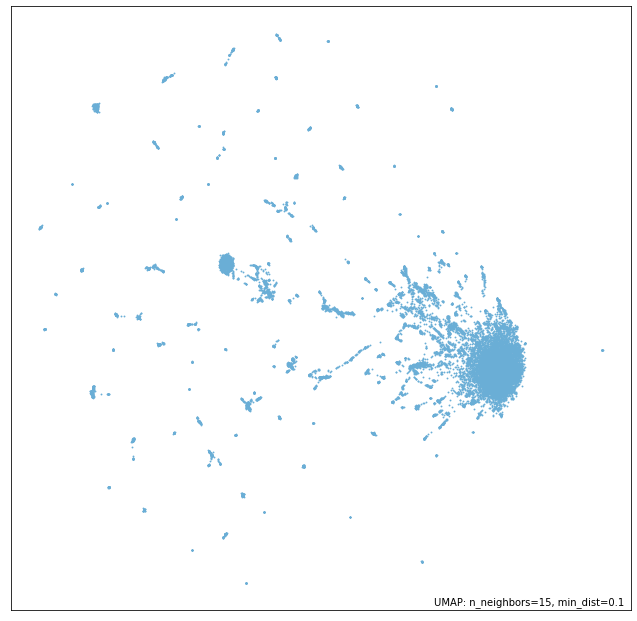

In [9]:
umap.plot.points(mapper)

In [10]:
# based on example at https://umap-learn.readthedocs.io/en/latest/basic_usage.html
import bokeh.plotting
import bokeh.models
import bokeh.palettes

datasource = bokeh.models.ColumnDataSource(embedding_df)

plot_title = 'UMAP projection of STRING proteins'
figure = bokeh.plotting.figure(
    title=plot_title,
    plot_width=600,
    plot_height=600,
    tools='box_zoom, pan, wheel_zoom, reset'
)

hover_tool = bokeh.models.HoverTool(
    tooltips=[
        ('symbol', '<i>@preferred_name</i>'),
        ('protein_size',  '@protein_size{,}'),
        ('info', '@annotation'),
    ],
)
figure.add_tools(hover_tool)

figure.circle(
    x='umap_0',
    y='umap_1',
    source=datasource,
    line_alpha=0.6,
    fill_alpha=0.6,
    radius=0.01
)

GlyphRenderer(id='1036', ...)

In [11]:
# Uncomment below to display plot in notebook
# bokeh.plotting.output_notebook()
# bokeh.plotting.show(plot_figure)

In [12]:
import bokeh.resources
bokeh.plotting.save(
    obj=figure,
    resources=bokeh.resources.CDN,
    title=plot_title,
    filename="data/embeddings/umap-2d-plot.html",
)

'/user/jupyter/data/embeddings/umap-2d-plot.html'